### Import

In [1507]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#plot
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

#technical analysis
import ta
import ta.momentum
import ta.volatility
import ta.volume

#### Ignore warnings

In [1508]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [1509]:
# df = pd.read_csv("./data/nasdaq/csv/INTC.csv", sep=',')
# df = pd.read_csv("./data/nasdaq/csv/BAC.csv", sep=',')
df = pd.read_csv("./data/nyse/csv/F.csv", sep=',')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.index = range(len(df))

df.tail()
df.set_index('Date', inplace=True)

all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(all_dates) 
df[['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']] = df[['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']].interpolate(method='linear')
df['Open'] = df['Close'].shift(1)
df['High'] = df[['High', 'Open', 'Close']].max(axis=1)
df['Low'] = df[['Low', 'Open', 'Close']].min(axis=1)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

### Add technical analysis indicators

#### RSI - Relative Strength Index

In [1510]:
df['RSI7'] = ta.momentum.RSIIndicator(df['Close'], window=7).rsi()
df['RSI14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['RSI30'] = ta.momentum.RSIIndicator(df['Close'], window=30).rsi()
df['RSI50'] = ta.momentum.RSIIndicator(df['Close'], window=50).rsi()

# df['MEAN_RSI7_5'] = df['RSI7'].rolling(window=5).mean()
# df['MEAN_RSI14_5'] = df['RSI14'].rolling(window=5).mean()
# df['MEAN_RSI30_5'] = df['RSI30'].rolling(window=5).mean()
# df['MEAN_RSI50_5'] = df['RSI50'].rolling(window=5).mean()

df['DRSI7'] = df['RSI7'].diff()
df['DRSI14'] = df['RSI14'].diff()
df['DRSI30'] = df['RSI30'].diff()

#### EMA RSI

In [1511]:
df['EMA7_RSI14'] = ta.trend.EMAIndicator(df['RSI14'], window=7).ema_indicator()
df['EMA14_RSI14'] = ta.trend.EMAIndicator(df['RSI14'], window=14).ema_indicator()
df['EMA7_RSI30'] = ta.trend.EMAIndicator(df['RSI30'], window=7).ema_indicator()
df['EMA14_RSI30'] = ta.trend.EMAIndicator(df['RSI30'], window=14).ema_indicator()

#### SMA - Simple Moving Average

In [1512]:
df['SMA5'] = ta.trend.SMAIndicator(df['Close'], window=5).sma_indicator()
df['SMA10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()
df['SMA14'] = ta.trend.SMAIndicator(df['Close'], window=14).sma_indicator()
df['SMA30'] = ta.trend.SMAIndicator(df['Close'], window=30).sma_indicator()
df['SMA50'] = ta.trend.SMAIndicator(df['Close'], window=50).sma_indicator()

#### EMA - Exponential Moving Average

In [1513]:
df['EMA5'] = ta.trend.EMAIndicator(df['Close'], window=5).ema_indicator()
df['EMA10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()
df['EMA14'] = ta.trend.EMAIndicator(df['Close'], window=14).ema_indicator()

#### KAMA - Kaufman's Adaptive Moving Average

In [1514]:
df['KAMA'] = ta.momentum.KAMAIndicator(close=df['Close']).kama()

#### ADX - Average Directional Movement

In [1515]:
df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14).adx()

#### EMA ADX

In [1516]:
df['EMA7_ADX'] = ta.trend.EMAIndicator(df['ADX'], window=7).ema_indicator()

#### Bollinger Bands

In [1517]:
bb = ta.volatility.BollingerBands(close=df['Close'], window=14)
df['HB'] = bb.bollinger_hband()
df['LB'] = bb.bollinger_lband()
df['MB'] = bb.bollinger_mavg()
df['%B'] = (df['Close'] - df['LB']) / (df['HB'] - df['LB'])
df['BBBandWidth'] = (df['HB'] - df['LB']) / df['MB']

In [1518]:
bb10 = ta.volatility.BollingerBands(close=df['Close'], window=10)
df['HB10'] = bb10.bollinger_hband()
df['LB10'] = bb10.bollinger_lband()
df['MB10'] = bb10.bollinger_mavg()
df['%B10'] = (df['Close'] - df['LB10']) / (df['HB10'] - df['LB10'])

In [1519]:
#consecutive days above sma20
df['AboveSMA20'] = (df['Close'] > df['MB']).astype(int)
df['DASMA'] = 0
consecutive_count = 0
r = np.zeros(len(df), dtype=int)
for i in range(1, len(df)):
    if df['AboveSMA20'].iloc[i]:
        consecutive_count += 1
    else:
        consecutive_count = 0
    r[i] = consecutive_count
df['DASMA'] = r
df.drop(['AboveSMA20'], axis=1, inplace=True)

In [1520]:
#consecutive days below sma20
df['BelowSMA20'] = (df['Close'] < df['MB']).astype(int)
df['DBSMA'] = 0
consecutive_count = 0
r = np.zeros(len(df), dtype=int)
for i in range(1, len(df)):
    if df['BelowSMA20'].iloc[i]:
        consecutive_count += 1
    else:
        consecutive_count = 0
    r[i] = consecutive_count
df['DBSMA'] = r
df.drop(['BelowSMA20'], axis=1, inplace=True)

In [1521]:
# EMA Bandwidth
df['EMA_BBBandWidth'] = ta.trend.EMAIndicator(df['BBBandWidth'], window=5).ema_indicator()

#### MACD

In [1522]:
df['MACD'] = ta.trend.MACD(df['Close']).macd()
df['MACD_signal'] = ta.trend.MACD(df['Close']).macd_signal()
df['MACD_hist'] = ta.trend.MACD(df['Close']).macd_diff()

#### Stochastic Oscillator

In [1523]:
df['SO'] = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close']).stoch()
df['EMA7_SO'] = ta.trend.EMAIndicator(df['SO'], window=7).ema_indicator()
df['EMA14_SO'] = ta.trend.EMAIndicator(df['SO'], window=14).ema_indicator()

#### On Balance Volume

In [1524]:
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume']).on_balance_volume()

#### Chaikin Money Flow

In [1525]:
df['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume']).chaikin_money_flow()

### Visualize

In [1526]:
start = 10400
# vdf = df
vdf = df[start:start+150]

fig = make_subplots(rows=9, cols=1)
#Price
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.HB, name='Bollinger High Band'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.LB, name='Bollinger Low Band'), row=1, col=1)
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.MB, name='Bollinger Middle Band'), row=1, col=1)
#SMA
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA5, name='SMA5'), row=2, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA10, name='SMA10'), row=2, col=1)
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA14, name='SMA14'), row=2, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA30, name='SMA30'), row=2, col=1)
# EMA
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.EMA5, name='EMA5'), row=3, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.EMA10, name='EMA10'), row=3, col=1)
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.EMA14, name='EMA14'), row=3, col=1)
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.KAMA, name='KAMA'), row=3, col=1)
#Bollinger Bands information
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf['%B'], name='%B'), row=4, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf['%B10'], name='%B10'), row=5, col=1)
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.BBBandWidth, name='BandWidth'), row=5, col=1)
# RSI
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.RSI30, name='RSI30'), row=6, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.RSI14, name='RSI14'), row=7, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.ADX, name='ADX'), row=8, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SO, name='SO'), row=9, col=1)

fig.update_layout(
    autosize=False,
    width=1500,
    height=1800,
    margin=dict(l=30,r=30,b=30,
                t=30,pad=3
                ),
    paper_bgcolor="White",
)

### Trend

In [1527]:
def calc_trend(df, n=5, threshold=0.01):
	trend = []	
	for i in range(len(df)):
		if i + n >= len(df):
			trend.append('Neutral')
			continue
		future_mean = df['Close'].iloc[i+1:i+n+1].mean()
		current_close = df['Close'].iloc[i]
		if future_mean > current_close * (1 + threshold):
			trend.append('Up')
		elif future_mean < current_close * (1 - threshold):
			trend.append('Down')
		else:
			trend.append('Neutral')
	df['Trend'] = trend
	return df

In [1528]:
def calc_trend_sma_ema(df, 
					   n=10, 
					   sma_threshold=0.01, 
					   ema_threshold=0.01):
	trend = []
	df['BBBandwidth_Q1'] = df['BBBandWidth'].rolling(window=100, min_periods=100).quantile(0.3)
	# df['BBBandwidth_Q1'] = df['BBBandWidth'].rolling(window=50, min_periods=100).quantile(0.3)
	for i in range(len(df)):
		if i + n >= len(df):
			trend.append('Neutral')
			continue
		# SMA
		future_sma10 = df['SMA10'].iloc[i + n]
		current_sma10 = df['SMA10'].iloc[i]
		# EMA
		future_ema10 = df['EMA14'].iloc[i + n]
		current_ema10 = df['EMA14'].iloc[i]

		future_close = df['Close'].iloc[i + n]

		# Bollinger Bands
		future_bandwidth = df['BBBandWidth'].iloc[i + n]
		future_bandwidth_q1 = df['BBBandwidth_Q1'].iloc[i + n]
		future_ema_bandwidth = df['EMA_BBBandWidth'].iloc[i + n]

		if ((future_sma10 > current_sma10 * (1 + sma_threshold)) and (future_ema10 > current_ema10 * (1 + ema_threshold))):
			trend.append('Up')
		elif (future_sma10 < current_sma10 * (1 - sma_threshold)) and (future_ema10 < current_ema10 * (1 - ema_threshold)):
			trend.append('Down')
		elif future_ema_bandwidth < future_bandwidth_q1 :
			trend.append('Neutral')
		else:
			trend.append('Unknown')
		
	assert(len(trend) == len(df))
	# df.drop(['BBBandWidth_Q1'], axis=1, inplace=True)
	df['Trend'] = trend
	return df
		

In [1529]:
df = calc_trend_sma_ema(df, n=7, sma_threshold=0.011, ema_threshold=0.02)
print(df['Trend'].value_counts())

Trend
Unknown    6603
Neutral    4780
Up         3698
Down       3376
Name: count, dtype: int64


In [1530]:
df[df['Date'] == '2001-03-22'][['Date', 'Close', 'SMA14', 'EMA10', 'EMA14', 'Trend']]

,Date,Close,SMA14,EMA10,EMA14,Trend
10521,2001-03-22,27.809999,29.227857,28.79333,28.864861,Unknown


In [1531]:
df[df['Date'] == '2001-03-29'][['Date', 'Close', 'SMA14', 'EMA10', 'EMA14', 'Trend']]

,Date,Close,SMA14,EMA10,EMA14,Trend
10528,2001-03-29,28.49,28.549286,28.451234,28.532624,Neutral


#### Delete invalid data

In [1532]:
df = df[200:-100]
# df = df[df['Trend'] != 'Unknown']
df.index = range(len(df))

In [1533]:
# df[5000:5010]

#### Indicator Analysis

In [1534]:
sma_threshold = 5
print(len(df[df['DASMA'] >= sma_threshold]))
print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Up')]))

5817
261
1483
2177


In [1535]:
print(len(df[df['DBSMA'] >= sma_threshold]))
print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Up')]))

5523
1987
1216
284


In [1536]:
upper_rsi_threshold = 70
print(len(df[df['RSI14'] > upper_rsi_threshold]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Up')]))


1723
25
157
1056


In [1537]:
lower_rsi_threshold = 30
print(len(df[df['RSI14'] < lower_rsi_threshold]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Up')]))

1468
954
66
14


In [1538]:
print(len(df[df['EMA7_RSI14'] < lower_rsi_threshold]))
print(len(df[(df['EMA7_RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['EMA7_RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['EMA7_RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Up')]))

1088
618
72
28


In [1539]:
upper_rsi_threshold = 70
print(len(df[df['EMA7_RSI14'] > upper_rsi_threshold]))
print(len(df[(df['EMA7_RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['EMA7_RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['EMA7_RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Up')]))

1275
36
156
689


In [1540]:
df.drop(['Open'], axis=1, inplace=True)
df.drop(['High'], axis=1, inplace=True)
df.drop(['Low'], axis=1, inplace=True)
df.drop(['Close'], axis=1, inplace=True)
df.drop(['Volume'], axis=1, inplace=True)
df.drop(['Adjusted Close'], axis=1, inplace=True)
df.drop(['HB'], axis=1, inplace=True)
df.drop(['LB'], axis=1, inplace=True)
df.drop(['MB'], axis=1, inplace=True)
df.drop(['HB10'], axis=1, inplace=True)
df.drop(['LB10'], axis=1, inplace=True)
df.drop(['MB10'], axis=1, inplace=True)
df.drop(['EMA5'], axis=1, inplace=True)
df.drop(['EMA10'], axis=1, inplace=True)
df.drop(['EMA14'], axis=1, inplace=True)
df.drop(['SMA5'], axis=1, inplace=True)
df.drop(['SMA10'], axis=1, inplace=True)
df.drop(['SMA14'], axis=1, inplace=True)
df.drop(['SMA30'], axis=1, inplace=True)
df.drop(['SMA50'], axis=1, inplace=True)
df.drop(['BBBandwidth_Q1'], axis=1, inplace=True)
df.drop(['KAMA'], axis=1, inplace=True)

### Train Model

In [1541]:
test_size = 0.3
test_split_idx  = int(df.shape[0] * (1-test_size))
train_df  = df.loc[:test_split_idx].copy()
test_df   = df.loc[test_split_idx:].copy()

In [1542]:
y_train = train_df['Trend'].copy()
X_train = train_df.drop(['Trend'], axis=1)

y_test  = test_df['Trend'].copy()
X_test  = test_df.drop(['Trend'], axis=1)

X_train = X_train.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12710 entries, 0 to 12709
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RSI7             12710 non-null  float64
 1   RSI14            12710 non-null  float64
 2   RSI30            12710 non-null  float64
 3   RSI50            12710 non-null  float64
 4   DRSI7            12710 non-null  float64
 5   DRSI14           12710 non-null  float64
 6   DRSI30           12710 non-null  float64
 7   EMA7_RSI14       12710 non-null  float64
 8   EMA14_RSI14      12710 non-null  float64
 9   EMA7_RSI30       12710 non-null  float64
 10  EMA14_RSI30      12710 non-null  float64
 11  ADX              12710 non-null  float64
 12  EMA7_ADX         12710 non-null  float64
 13  %B               12710 non-null  float64
 14  BBBandWidth      12710 non-null  float64
 15  %B10             12710 non-null  float64
 16  DASMA            12710 non-null  int64  
 17  DBSMA       

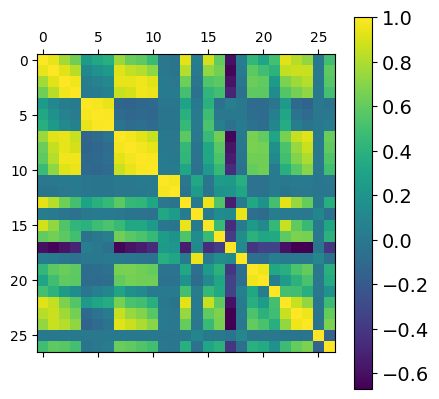

In [1543]:
corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')
plt.matshow(corr)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [1544]:
le = LabelEncoder()
le.fit(['Up', 'Down', 'Neutral', 'Unknown'])
y_train = le.transform(y_train)
y_test = le.transform(y_test)
le.transform(['Up', 'Down', 'Neutral', 'Unknown'])

array([3, 0, 1, 2])

In [1545]:
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [1546]:
rus = RandomUnderSampler(random_state=42)
X_test, y_test = rus.fit_resample(X_test, y_test)

(array([4731., 4731., 4731., 4731.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

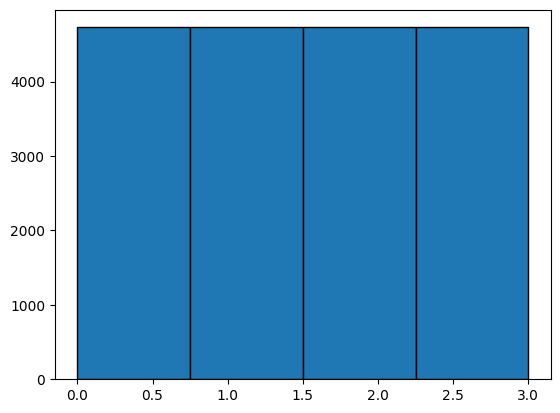

In [1547]:
# plt.hist(y_train, bins=3, edgecolor='black')
plt.hist(y_train, bins=4, edgecolor='black')

(array([1122., 1122., 1122., 1122.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

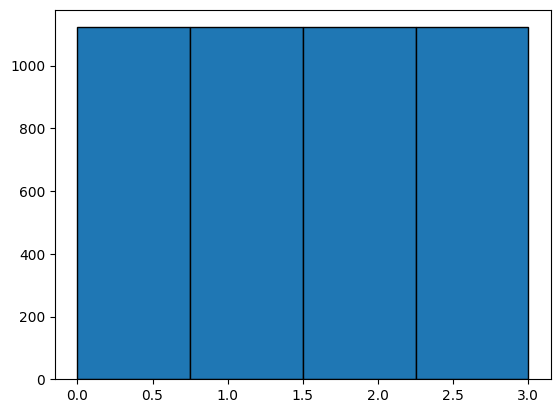

In [1548]:
# plt.hist(y_test, bins=3, edgecolor='black')
plt.hist(y_test, bins=4, edgecolor='black')

In [1549]:
%%time

param_grid = {
    'max_depth': [10],
    'learning_rate': [0.1],
    'n_estimators': [425],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.8, 1.0],
}

# model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# Thiết lập GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Tối ưu hóa dựa trên accuracy
    n_jobs=3, 
    verbose=1
)

# Huấn luyện GridSearchCV
grid_search.fit(X_train, y_train)

# In tham số tốt nhất và điểm số
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 425, 'subsample': 0.6}
Best Cross-Validation Accuracy: 0.6657154935531601
CPU times: total: 2min 24s
Wall time: 2min 25s


In [1550]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.4962

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.48      0.52      1122
           1       0.51      0.51      0.51      1122
           2       0.34      0.43      0.38      1122
           3       0.63      0.57      0.59      1122

    accuracy                           0.50      4488
   macro avg       0.51      0.50      0.50      4488
weighted avg       0.51      0.50      0.50      4488


Confusion Matrix:
[[544 145 376  57]
 [158 568 254 142]
 [216 246 480 180]
 [ 34 164 289 635]]


In [1551]:
le.transform(['Up', 'Down', 'Neutral', 'Unknown'])

array([3, 0, 1, 2])

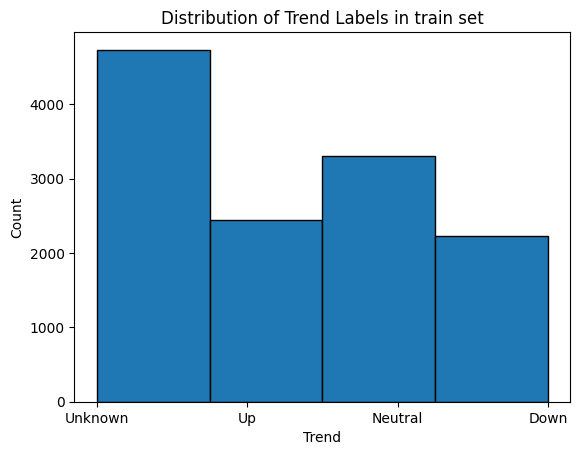

In [1552]:
# plt.hist(train_df['Trend'], bins=3, edgecolor='black')
plt.hist(train_df['Trend'], bins=4, edgecolor='black')
plt.title('Distribution of Trend Labels in train set')
plt.xlabel('Trend')
plt.ylabel('Count')
plt.show()

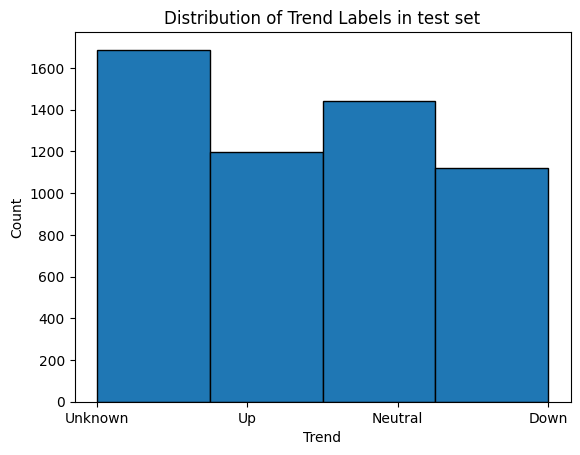

In [1553]:
# plt.hist(test_df['Trend'], bins=3, edgecolor='black')
plt.hist(test_df['Trend'], bins=4, edgecolor='black')
plt.title('Distribution of Trend Labels in test set')
plt.xlabel('Trend')
plt.ylabel('Count')
plt.show()

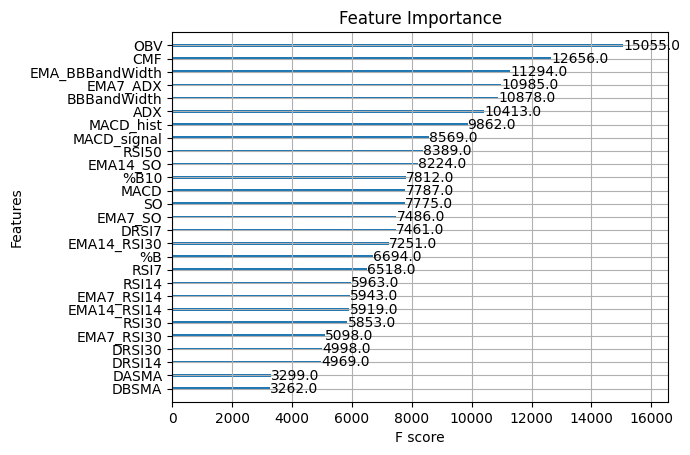

In [1554]:
xgb.plot_importance(best_model)
plt.title('Feature Importance')
plt.show()